**기본 세팅**

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

---

# 16. CNN

이번 챕터에선 딥러닝을 이용해서 이미지 인식을 해보자.

## 16.1 데이터 전처리

데이터는 0부터 10까지의 숫자 이미지에 대한 MNIST 데이터를 이용한다.

In [3]:
from keras.datasets import mnist

(X_train, Y_class_train), (X_test, Y_class_test) = mnist.load_data()

print(f"train 이미지 수: {X_train.shape[0]:,}")
print(f"test 이미지 수: {X_test.shape[0]:,}")

Using TensorFlow backend.


train 이미지 수: 60,000
test 이미지 수: 10,000


- MNIST 데이터는 `keras.datasets`의 `mnist.load_data()`를 이용해서 불러올 수 있다.


- `keras`의 MNIST 데이터는 총 70,000개의 데이터를 60,000개의 train과 10,000개의 test로 미리 구분해 놓았다.

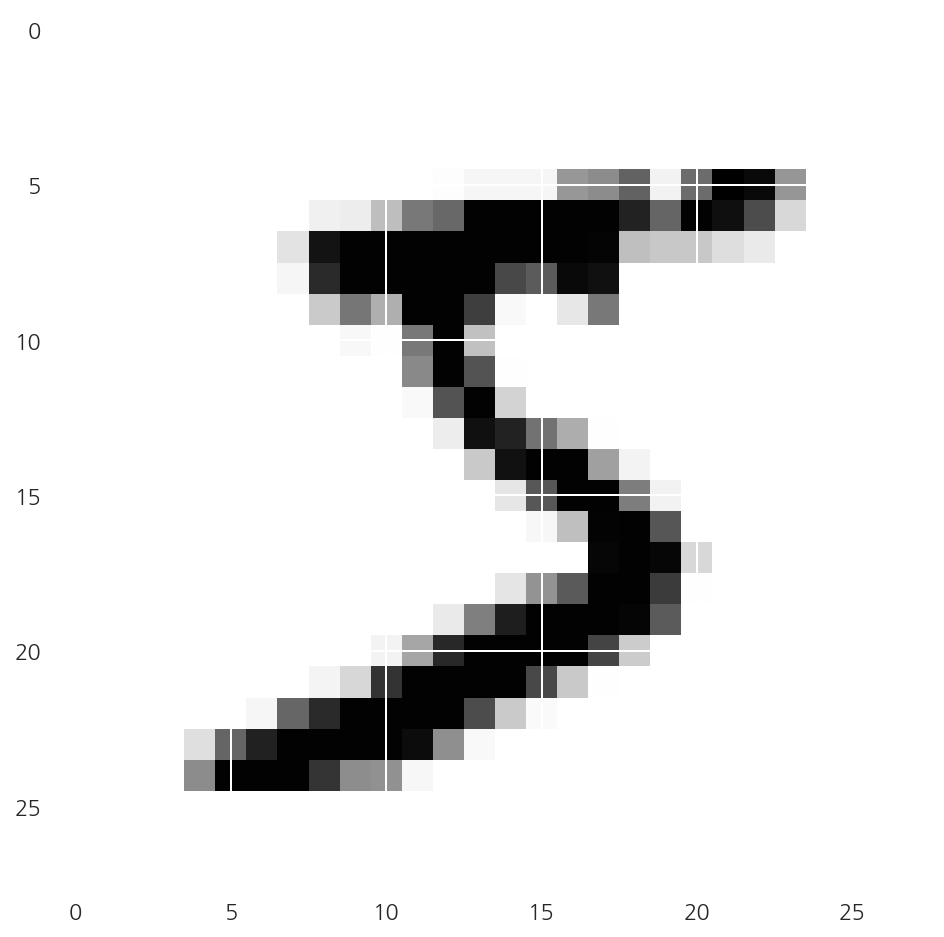

In [4]:
plt.imshow(X_train[0], cmap="Greys")
plt.show()

- 먼저 train의 이미지 중 첫 번째 이미지를 `plt.imshow()`를 이용해 출력하였다.

In [5]:
X_train[0].shape

(28, 28)

- 앞서 확인한 이미지는 28 x 28 = 784개의 픽셀로 이루어져 있다.


- 각 픽셀은 밝기 정도에 따라 0~255까지 등급을 매긴다.


- 흰색 배경이 0이라면 글씨가 있는 곳은 1~255까지의 숫자 중 하나로 채워진 행렬로 이루어져 있는 것이다.

In [6]:
import sys

# 행 단위 for
for x in X_train[0]:
    # 열 단위 for (행 index for)
    for i in x:
        sys.stdout.write(f"{str(i).zfill(3)} ")
    
    sys.stdout.write("\n")

000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 000 
000 000 000 000 000 000 000 000 000 000 000 000 003 018 018 018 126 136 175 026 166 255 247 127 000 000 000 000 
000 000 000 000 000 000 000 000 030 036 094 154 170 253 253 253 253 253 225 172 253 242 195 064 000 000 000 000 
000 000 000 000 000 000 000 049 238 253 253 253 253 253 253 253 253 251 093 082 082 056 039 000 000 000 000 000 
000 000 000 000 000 000 000 018 219 253 253 253 253 253 198 182 247 241 000 000 000 000 000 000 

- 각 픽셀별 밝기 등급을 확인하였다.


- 참고로 `sys.stdout.write()`는 `print()`와 비슷하지만 자동 줄바꿈을 하지 않는다.


- 그냥 출력하면 숫자 길이가 달라서 정사각형 모양이 안나와서 `zfill()`을 사용하였다.

In [7]:
X_train.shape

(60000, 28, 28)

- 다시 한번 확인하면 train은 총 60,000개의 이미지가 각각 28 x 28 = 784개의 픽셀로 이루어져 있다.


- 모델 학습을 위해 이를 2차원으로 변경할 필요가 있다.

In [8]:
# 2차원 배열로 변경
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_train.shape

(60000, 784)

- 행렬로 구성된 각 이미지별 정보를 모두 피처로, 즉 60,000 x 784로 이루어진 2차원 배열로 변경하였다.

In [9]:
# 참고
a = np.array([
    [[1,2], 
     [3,4]],
    
    [[5,6],
     [7,8]]
])
print(a)
print("-"*10)
print(a.reshape(2,4))

[[[1 2]
  [3 4]]

 [[5 6]
  [7 8]]]
----------
[[1 2 3 4]
 [5 6 7 8]]


- 직관적으로 이해하기 위해 참고로 3차원 배열을 2차원으로 변경하는 간단한 예시를 만들었다.

In [10]:
# 정규화 (MinMaxScaler)
X_train = X_train.astype("float64")
X_train = X_train / 255

- keras는 데이터를 0~1 사이의 값으로 변환 후 구동할 때 최적의 성능을 보인다고 한다.


- 따라서 데이터를 정규화 시켜주었다.


- 사실상 `MinMaxScaler()`를 적용한 것인데 [사이킷런 소개](https://romg2.github.io/mlguide/01_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C-02.-%EC%82%AC%EC%9D%B4%ED%82%B7%EB%9F%B0-%EC%86%8C%EA%B0%9C/)에서 공부하였으니 참고하자.

In [11]:
# test 동일 작업
X_test = X_test.reshape(X_test.shape[0], 28*28)
X_test = X_test.astype("float64")
X_test = X_test / 255

- test에도 동일한 작업을 적용한다.

In [12]:
Y_class_train[0]

5

- 앞서 첫 번째 이미지를 시각화 하였을 때 값은 5의 이미지였다.


- target 값 역시 5로 잘 입력되어 있으나 이를 원-핫 인코딩으로 바꿔주려 한다.


- 참고로 [다중 분류](https://romg2.github.io/dl_all/05-%EB%AA%A8%EB%91%90%EC%9D%98-%EB%94%A5%EB%9F%AC%EB%8B%9D-04.-%EB%94%A5%EB%9F%AC%EB%8B%9D-%EA%B8%B0%EB%B3%B8%EA%B8%B0-%EB%8B%A4%EC%A7%80%EA%B8%B0-(3)/)에선 target을 원-핫 인코딩 했으나 머신러닝 완벽가이드에선 target을 원-핫 인코딩 한 적은 없다.

In [13]:
from keras.utils import np_utils

# target 원-핫 인코딩
Y_train = np_utils.to_categorical(Y_class_train,10)
Y_test = np_utils.to_categorical(Y_class_test,10)

- 원-핫 인코딩을 수행하는 코드가 정말 다양한 듯 하다.


- 여기선, `keras.utils`의 `np_utils.to_categorical()`을 사용하였다.

## 16.2 딥러닝 기본 프레임

이전 챕터들을 공부하면서 배운대로 딥러닝 모델을 실행해보자.

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 모델 설정
model = Sequential()
model.add(Dense(512, input_dim=784, activation="relu"))
model.add(Dense(10, activation="softmax"))

- 모델은 하나의 은닉층을 가지며 다중 분류이므로 출력층에서 적용할 활성화 함수를 softmax를 사용하였다.

In [15]:
# 모델 컴파일
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

- 오차 함수로는 역시 다중 분류이므로 categorical_crossentropy를 사용하였다.

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os

# 해당 폴더가 존재하지 않으면 폴더 생성
model_dir = "./model"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
# 모델 저장 경로 지정
modelpath = "./model/{epoch:04d}-{val_loss:.4f}.hdf5"

# 모델 저장 조건 설정
checkpointer = ModelCheckpoint(filepath=modelpath, monitor="val_loss",
                               verbose=1, save_best_only=True)

# 모델 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10)

- 모델 저장 조건과 조기 중단 조건을 설정하였다.

In [17]:
import tensorflow as tf
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 시드 설정
np.random.seed(0)
tf.random.set_seed(3)

# MNIST 데이터 불러오기
(X_train, Y_class_train), (X_test, Y_class_test) = mnist.load_data()

# 2차원 배열로 변경
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# 정규화 (MinMaxScaler)
X_train = X_train.astype("float64") / 255
X_test = X_test.astype("float64") / 255

# target 원-핫 인코딩
Y_train = np_utils.to_categorical(Y_class_train,10)
Y_test = np_utils.to_categorical(Y_class_test,10)

# 모델 설정
model = Sequential()
model.add(Dense(512, input_dim=784, activation="relu"))
model.add(Dense(10, activation="softmax"))

# 모델 컴파일
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 모델 저장 조건 설정
checkpointer = ModelCheckpoint(filepath=modelpath, monitor="val_loss",
                               verbose=1, save_best_only=True)

# 모델 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10)

# 모델 실행
history1 = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                     epochs=30, batch_size=200, 
                     verbose = 0, 
                     callbacks = [checkpointer, early_stopping_callback])

# 결과 출력
print("-"*100)
print(f"Accuracy: {model.evaluate(X_test, Y_test, verbose=0)[1]: .4f}")


Epoch 00001: val_loss improved from inf to 0.15306, saving model to ./model/0001-0.1531.hdf5

Epoch 00002: val_loss improved from 0.15306 to 0.10264, saving model to ./model/0002-0.1026.hdf5

Epoch 00003: val_loss improved from 0.10264 to 0.08620, saving model to ./model/0003-0.0862.hdf5

Epoch 00004: val_loss improved from 0.08620 to 0.07359, saving model to ./model/0004-0.0736.hdf5

Epoch 00005: val_loss improved from 0.07359 to 0.06934, saving model to ./model/0005-0.0693.hdf5

Epoch 00006: val_loss improved from 0.06934 to 0.06715, saving model to ./model/0006-0.0672.hdf5

Epoch 00007: val_loss improved from 0.06715 to 0.06626, saving model to ./model/0007-0.0663.hdf5

Epoch 00008: val_loss improved from 0.06626 to 0.05932, saving model to ./model/0008-0.0593.hdf5

Epoch 00009: val_loss did not improve from 0.05932

Epoch 00010: val_loss improved from 0.05932 to 0.05931, saving model to ./model/0010-0.0593.hdf5

Epoch 00011: val_loss did not improve from 0.05931

Epoch 00012: val_

- 앞서 수행한 과정들과 모델 실행까지의 코드를 작성하였다.


- `fit()`에서 `validation_data`로 test 데이터를 사용하였다.


- 용어 정리가 필요할 듯 한데 실제론 `evaluate()`에서 test 데이터를 사용하고 중간 평가를 validation 데이터를 사용할 것이다.


- 교재에서는 모두 test 데이터라고 용어를 사용하는데 이해하기 쉬우라고 그런 듯 하다.


- epoch은 30으로 설정하였으나 20에서 조기 중단되었다.

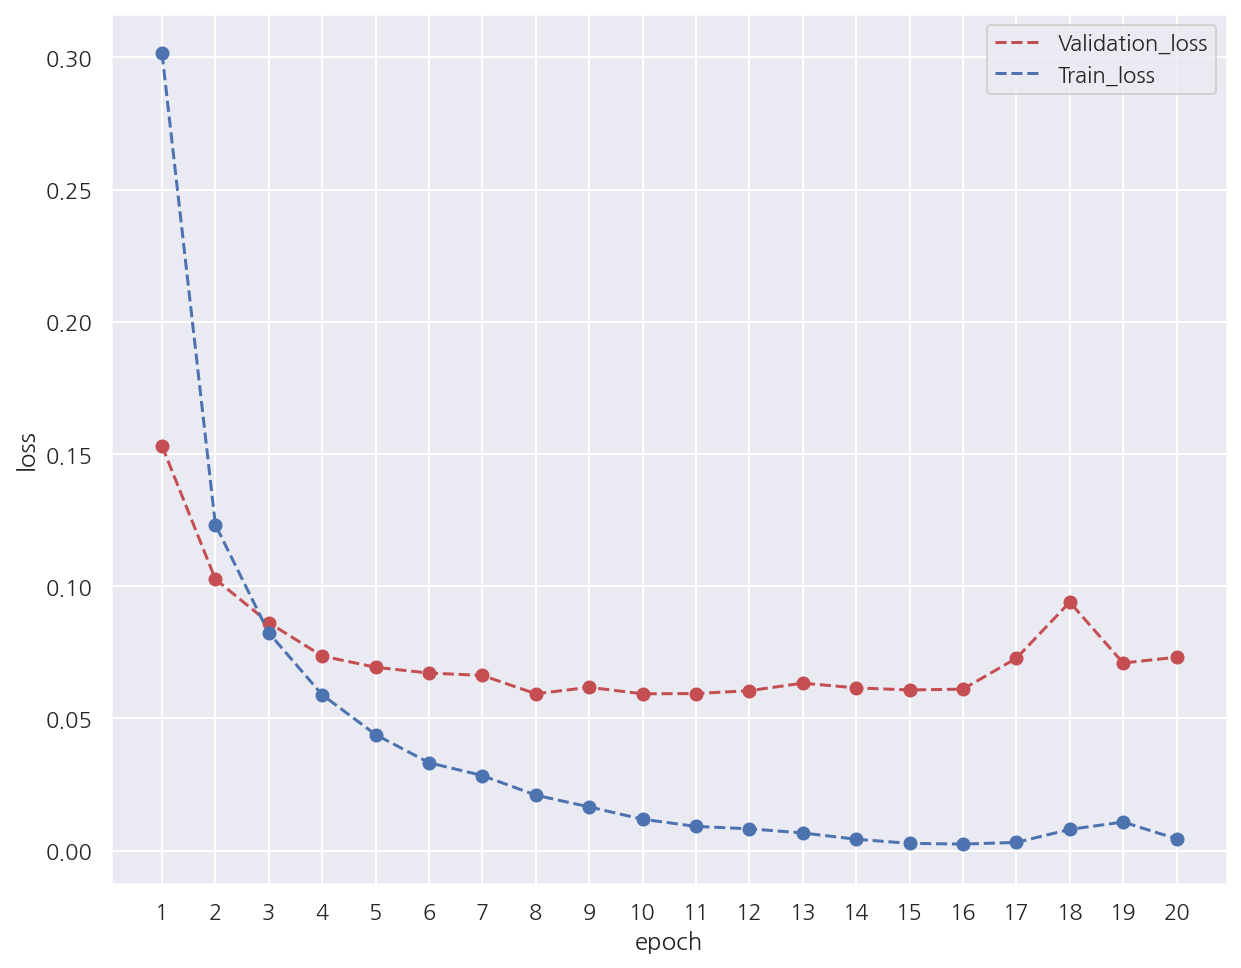

In [18]:
# validation 오차, train 오차 시각화
y_vloss = history1.history["val_loss"]
y_loss = history1.history["loss"]       # 여기서 오차: (1 - 정확도)
x_len = np.arange(len(y_loss))

# validation 오차
plt.plot(x_len + 1, y_vloss, "r--", label="Validation_loss")
plt.scatter(x_len + 1, y_vloss, color="r")

# train 오차
plt.plot(x_len + 1, y_loss, "b--", label="Train_loss")
plt.scatter(x_len + 1, y_loss)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.xticks(range(1,21))
plt.show()

- train 오차는 마지막 쯤에는 살짝 증가하지만 전반적으로 epoch가 증가함에 따라 감소한다.


- 조기 중단을 설정하였기에 train에 과적합 되기 전에 학습을 중단하였다.


- 정확하게는 epoch가 10 이후 10번 반복동안 validation_loss가 낮아지지 않음을 확인 가능하다.

## 16.3 CNN

이번엔 컨볼루션 신경망(Convolutional Neural Networks: CNN)을 이용해서 이미지를 분류해보자.

CNN은 입력된 이미지에서 다시 한번 특징을 추출하기 위해 커널(슬라이딩 윈도)을 도입하는 기법이다.

### 16.3.1 컨볼루션(합성곱)

먼저 컨볼루션(합성곱)에 대해 알아보기 위해 다음과 같은 이미지 데이터가 있다고 가정하자.

![](https://thebook.io/img/080228/228_1.jpg)

출처: <https://thebook.io/080228/part05/ch16/04/>

다음으로 각 칸에 가중치가 존재하는 2 x 2 커널을 준비하자.

![](https://thebook.io/img/080228/228_2.jpg)

출처: <https://thebook.io/080228/part05/ch16/04/>

이 커널을 이미지 데이터에 맨 왼쪽 위칸부터 차례대로 다음과 같이 적용한다.

![](https://thebook.io/img/080228/229_1.jpg)

출처: <https://thebook.io/080228/part05/ch16/04-02/>

최종 결과는 다음과 같이 나타난다.

![](https://thebook.io/img/080228/229_2.jpg)

출처: <https://thebook.io/080228/part05/ch16/04-03/>

이렇게 해서 새롭게 만들어진 층을 컨볼루션(합성곱)이라고 한다.

컨볼루션을 만들면 입력 데이터로부터 더욱 정교한 특징을 추출할 수 있다.

즉, 입력 데이터를 좀 더 중요한 특징을 가지게 변경하는 작업이다.

In [19]:
from tensorflow.keras.layers import Conv2D

model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28,28,1), activation="relu"))

- `Conv2D()`를 사용하면 컨볼루션 층을 추가할 수 있다.


- 첫 번째 인자는 커널을 몇 개 적용할지 정하며, 여기선 32개의 커널을 사용해 32개의 컨볼루션을 만든다.


- `kernel_size`는 커널의 크기를 지정하며, 여기선 3 x 3 크기로 지정하였다.


- `input_shape`는 맨 처음 층에 입력되는 값을 지정하며, (행, 열, 색상 또는 흑백)으로 이미지가 색상이면 3 흑백이면 1을 지정한다.


- `activation`은 활성화 함수를 지정한다.

In [20]:
model.add(Conv2D(64, (3,3), activation="relu"))

- 컨볼루션 층을 하나 더 추가하였다.


- 3 x 3 크기의 커널을 64개 적용하여 64개의 컨볼루션 층을 만든다.

### 16.3.2 맥스 풀링

컨볼루션 층을 통해 이미지 데이터의 특징을 추출하였으나 그 결과가 여전히 크고 복잡하면 이를 다시 한번 축소해야 한다.

이 과정을 풀링(pooling) 또는 서브 샘플링(sub sampling)이라고 한다.

풀링을 사용하면 과적합을 억제하며 특징을 더 잘 추출할 수 있다.

대표적인 풀링 방법은 다음과 같다.

- 맥스 풀링: 정해진 구역 안에서 최대값을 뽑아내는 방식으로 보편적으로 사용된다.


- 평균 풀링: 정해진 구역 안에서 평균값을 뽑아내는 방식

다음과 같은 컨볼루션 결과가 1개 있다고 하자.

![](https://thebook.io/img/080228/232_1.jpg)

출처: <https://thebook.io/080228/part05/ch16/05/>

맥스 풀링을 적용하면 다음과 같이 구역을 나눈다.

![](https://thebook.io/img/080228/232_2.jpg)

출처: <https://thebook.io/080228/part05/ch16/05-01/>

그 후 각 구역별 최대값을 추출하여 불필요한 정보를 간추린다.

![](https://thebook.io/img/080228/232_3.jpg)

출처: <https://thebook.io/080228/part05/ch16/05-01/>

In [21]:
from tensorflow.keras.layers import MaxPooling2D

model.add(MaxPooling2D(pool_size=2))

- `MaxPooling2D()`를 이용해서 맥스 풀링을 수행할 수 있다.


- `pool_size`로 풀링 창의 크기를 정하며 2로 정하면 전체 크기가 절반으로 줄어든다.


- 앞서 28 x 28 데이터를 3 x 3 커널을 이용해 32개의 컨볼루션을 만들었다.


- 각 컨볼루션은 28 - 3 + 1 = 26 x 26 으로 이루어져 있을 것이다.


- 두 번째 컨볼루션 층 역시 3 x 3 커널을 이용해 26 - 3 + 1 = 24 x 24로 이루어진 컨볼루션을 64개 만든다.


- `pool_size`를 2로 설정하였기에 24 / 2 = 12 x 12 로 이루어진 64개의 컨볼루션이 만들어질 것이다.

### 16.3.3 드롭 아웃

노드나 층이 많다고 학습이 무조건 좋아지지 않으며 오히려 과적합 문제가 발생할 수 있다.

과적합 문제를 방지하는 기법 중 하나가 드롭 아웃이다.

드롭 아웃은 은닉층에 배치된 노드 중 일부를 랜덤으로 꺼주는 역할을 한다.

다음 그림을 참고하자.

![](https://thebook.io/img/080228/234.jpg)

출처: <https://thebook.io/080228/part05/ch16/05-03/>

In [22]:
from tensorflow.keras.layers import Dropout

model.add(Dropout(0.25))

- 위 코드는 `Dropout()`을 이용해서 25%의 노드를 랜덤하게 끈다.

In [23]:
from tensorflow.keras.layers import Flatten

model.add(Flatten())

- 컨볼루션 층이나 맥스 풀링은 데이터를 2차원 배열인 채로 다룬다.


- 이를 1차원 배열로 바꿔야 활성화 함수가 있는 층에서 사용 가능하므로 `Flatten()`으로 1차원 배열로 바꿔준다.

### 16.3.4 CNN 실행

지금까지 확인한 내용으로 CNN을 실행해보자.

모델 구조는 다음과 같은 형태로 구성할 것이며 노드 수와 드롭 아웃 비율만 일부 수정한다.

![](https://thebook.io/img/080228/235.jpg)

출처: <https://thebook.io/080228/part05/ch16/05-04/>

In [24]:
from keras.datasets import mnist
from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

# 시드 설정
np.random.seed(0)
tf.random.set_seed(3)

# 데이터 불러오기
(X_train, Y_class_train), (X_test, Y_class_test) = mnist.load_data()

# 정규화 (MinMaxScaler) 
# batches x row x col x channel: 60,000 x 28 x 28 x 1(흑백 채널 1개)
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype("float32") / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype("float32") / 255

# target 원-핫 인코딩
Y_train = np_utils.to_categorical(Y_class_train)
Y_test = np_utils.to_categorical(Y_class_test)

# CNN 설정
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(28, 28, 1), activation="relu"))
model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# 모델 컴파일
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# 해당 폴더가 존재하지 않으면 폴더 생성
model_dir = "./model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
# 모델 저장 경로 및 조건 설정
modelpath = "./model/{epoch:04d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor="val_loss",
                               verbose=1, save_best_only=True)

# 모델 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=10)

# 모델 실행
history2 = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), 
                     epochs=30, batch_size=200, 
                     verbose = 0, 
                     callbacks = [checkpointer, early_stopping_callback])

# 결과 출력
print("-"*100)
print(f"Accuracy: {model.evaluate(X_test, Y_test, verbose=0)[1]: .4f}")


Epoch 00001: val_loss improved from inf to 0.05108, saving model to ./model/0001-0.0511.hdf5

Epoch 00002: val_loss improved from 0.05108 to 0.03808, saving model to ./model/0002-0.0381.hdf5

Epoch 00003: val_loss improved from 0.03808 to 0.03205, saving model to ./model/0003-0.0320.hdf5

Epoch 00004: val_loss did not improve from 0.03205

Epoch 00005: val_loss improved from 0.03205 to 0.03135, saving model to ./model/0005-0.0314.hdf5

Epoch 00006: val_loss improved from 0.03135 to 0.03077, saving model to ./model/0006-0.0308.hdf5

Epoch 00007: val_loss improved from 0.03077 to 0.02924, saving model to ./model/0007-0.0292.hdf5

Epoch 00008: val_loss did not improve from 0.02924

Epoch 00009: val_loss did not improve from 0.02924

Epoch 00010: val_loss did not improve from 0.02924

Epoch 00011: val_loss improved from 0.02924 to 0.02884, saving model to ./model/0011-0.0288.hdf5

Epoch 00012: val_loss improved from 0.02884 to 0.02882, saving model to ./model/0012-0.0288.hdf5

Epoch 00013

- 우선 수행 시간이 굉장히 오래 걸리므로 GPU 환경에서 돌려야할 것 같다.


- 앞서 딥러닝 기본 프레임에서는 정확도가 98.27%로 나타났는데 99.28%로 정확도가 향상되었다.

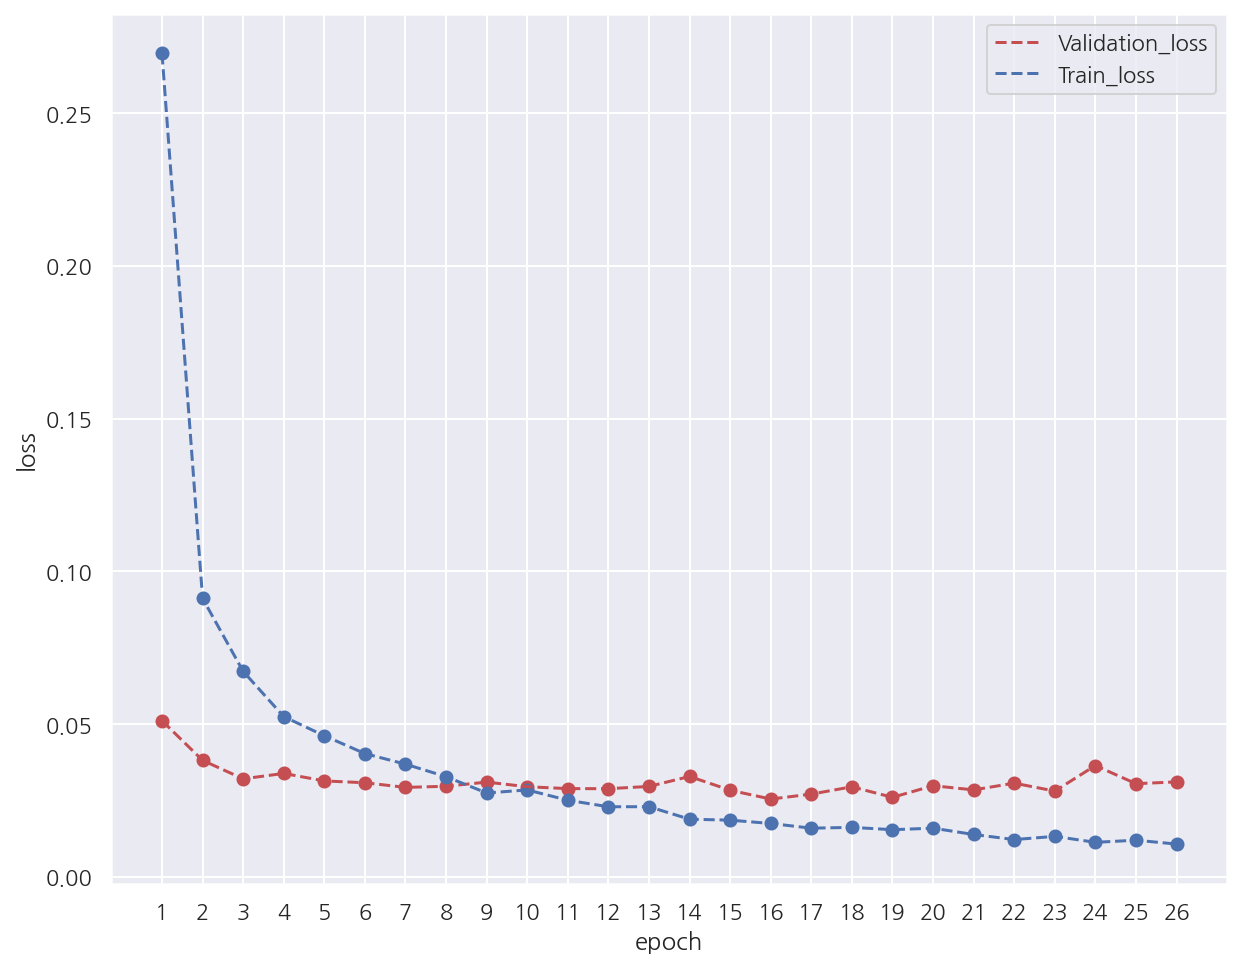

In [27]:
# validation 오차, train 오차 시각화
y_vloss = history2.history["val_loss"]
y_loss = history2.history["loss"]       # 여기서 오차: (1 - 정확도)
x_len = np.arange(len(y_loss))

# validation 오차
plt.plot(x_len + 1, y_vloss, "r--", label="Validation_loss")
plt.scatter(x_len + 1, y_vloss, color="r")

# train 오차
plt.plot(x_len + 1, y_loss, "b--", label="Train_loss")
plt.scatter(x_len + 1, y_loss)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.xticks(range(1,27))
plt.show()

- 앞서 딥러닝 기본 프레임에 비해 validation_loss가 낮음을 확인 할 수 있다.